# ASTR 596: The Final

#### Three questions, each worth a third of your grade. (I'll make one 34 pts to get to an even 100). Each is designed to test an area where I think the class as a whole is less comfortable. They are sorted by my assesment of difficulty from easiest to hardest. 
#### i.e. the last is probably going to be non-trivial, because well I like Gaussian distributions of grades. 
#### That's OK because the points and grades don't matter!

#### Remember, you can work together, discuss problems and solutions, but you have to write up your own solution. I'd strongly suggest doing that, ideally with some divide and conquer strategy.

### Q1. Using unsupervised learning to work with galaxies

The following query will select 20k likely galaxies from the SDSS database and return the results of that query into an `astropy Table`.  (For now, if you are not familiar with the SDSS DB schema, don't worry about this query, just know that it returns a bunch of photometric features.)

In [513]:
# %matplotlib notebook
# %pylab
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.sdss import SDSS  # enables direct queries to the SDSS database

GALquery = """SELECT TOP 20000 
         p.dered_u - p.dered_g as ug, p.dered_g - p.dered_r as gr, 
         p.dered_g - p.dered_i as gi, p.dered_g - p.dered_z as gz,             
         p.petroRad_i, p.petroR50_i, p.deVAB_i, p.fracDev_i
         FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
         WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND p.type = 3
         AND p.deVAB_i > -999 AND p.petroRad_i > -999 AND p.petroR50_i > -999 AND p.dered_r < 20
           """
SDSSgals = SDSS.query_sql(GALquery)
SDSSgals

<Table length=20000>
    ug        gr        gi        gz    petroRad_i petroR50_i  deVAB_i  fracDev_i
 float64   float64   float64   float64   float64    float64    float64   float64 
--------- --------- --------- --------- ---------- ---------- --------- ---------
 1.999718 0.9592915  1.370582  1.692535   5.454633   2.344662 0.8708095       1.0
  1.98884 0.9332962  1.361919  1.668918   5.177937   2.424093 0.9946066 0.8865207
 1.020407  1.601521  2.396175  2.827263   5.846272   1.158836 0.6898293       1.0
  1.83742  1.211882  1.688545  1.989878   7.145427   2.795447 0.7493948       1.0
  4.55904  1.536175   2.29286  2.712597   4.741546    2.09032 0.5173162 0.8244159
 4.532835  1.433081  2.251518  2.669952   8.930706   1.656738 0.6116931       1.0
 2.075247  1.267462  1.746914  2.053957   5.091534   2.249913 0.6196061       1.0
 1.677757  1.102043  1.582317  1.902397     6.5472   2.809995 0.8713289 0.9118057
 1.858603 0.9054127  1.364218  1.661177   6.641626    2.84336    0.4171       1.0
   2.1474  1.623241  2.260538  2.703392   2.730807   1.252324 0.3585599 0.6629297
 2.596178  1.578781  2.520107  3.093014    2.63223   1.165497 0.4484372       0.0
      ...       ...       ...       ...        ...        ...       ...       ...
 1.298388  1.907398  2.764206  3.271784   3.762364   1.463835 0.6918103       1.0
0.9023361 0.5580044  0.911459  1.108555   3.681817   1.720722  0.721666 0.8195741
 1.857777 0.9620533  1.460201  1.855776   4.410516   1.886131 0.2076729 0.6522976
 1.318602 0.9129581  1.384508   1.71521   4.262115   2.047355 0.7254996 0.3429224
 1.928383  1.363815  2.001547  2.503323   3.772788   1.627743 0.3971493       1.0
 1.528563 0.7446737  1.127333  1.447868   7.086716   3.289843 0.6890883 0.6699128
0.9577446 0.3013992 0.4048061 0.5041103   6.025708   2.137799 0.3689274 0.8930099
 1.967268  1.856213  2.554731   3.04155   3.631061   1.507525 0.6138228       1.0
 1.949785  1.700554   2.31209  2.640701   4.792744   2.022157 0.7903708       1.0
 1.235653  0.590229 0.8989735  1.101547   3.625606   1.790074 0.5999171       0.0
 1.624931  1.043297  1.513315  1.823009   3.496078   1.539961 0.4506327 0.8605426

### 1a - Visualize the dataset in g-i (y) vs u-g (x) and all the features (11 pts). 

The bluest galaxies are star-forming galaxies at low redshift 𝑧. The "tight" cluster of red galaxies are passive galaxies at low-𝑧. Finally the diffuse cloud at 𝑔−𝑖≈3 are high-𝑧 luminous red galaxies (LRGs) that were targeted for BAO measurements. These sources have a wide range of 𝑢−𝑔 colors because they essentially are not detected in the 𝑢 band as this is blueward of the Lyman break.

Plot and examine each of the features in this data set using seaborn's `PairGrid`. Overlay a histogram and kernel density distribution (KDE) on each 1D and 2D plot. You should be able to roughly see the different groups of galaxies, but how to separate them?

In [514]:
import seaborn as sns
from scipy import stats

In [515]:
sdg=SDSSgals.to_pandas()

In [516]:
def w2(ws):
    trs = ws
    tv=trs.values
    avg = np.mean(tv,axis=0)
    # print(avg)
    wog = abs(tv) < (avg+np.std(tv,axis=0)*(1/20))
    return ws.iloc[wog.all(axis=1)]

In [517]:
sdw=w2(sdg)
sdw

ug        gr        gi        gz  petroRad_i  petroR50_i  \
9      2.147400  1.623241  2.260538  2.703392    2.730807    1.252324   
10     2.596178  1.578781  2.520107  3.093014    2.632230    1.165497   
16     2.070011  2.026037  2.890808  3.463774    2.534473    1.295210   
35     2.747646  1.348701  1.988771  2.354734    1.672172    0.826427   
42     1.867847  0.797886  1.181081  1.485455    5.165435    2.117622   
...         ...       ...       ...       ...         ...         ...   
19963  0.966980  1.169653  1.640263  2.011936    3.502914    1.632023   
19964  1.285223  1.181530  1.695267  2.170067    2.969577    1.289617   
19970  0.718504  0.164825  0.404163  0.432831    2.879645    1.300424   
19991  1.857777  0.962053  1.460201  1.855776    4.410516    1.886131   
19998  1.235653  0.590229  0.898973  1.101547    3.625606    1.790074   

        deVAB_i  fracDev_i  
9      0.358560   0.662930  
10     0.448437   0.000000  
16     0.600124   0.569432  
35     0.099868   0.000000  
42     0.275848   0.759422  
...         ...        ...  
19963  0.637921   0.000000  
19964  0.575338   0.567637  
19970  0.426555   0.526495  
19991  0.207673   0.652298  
19998  0.599917   0.000000  

[2182 rows x 8 columns]

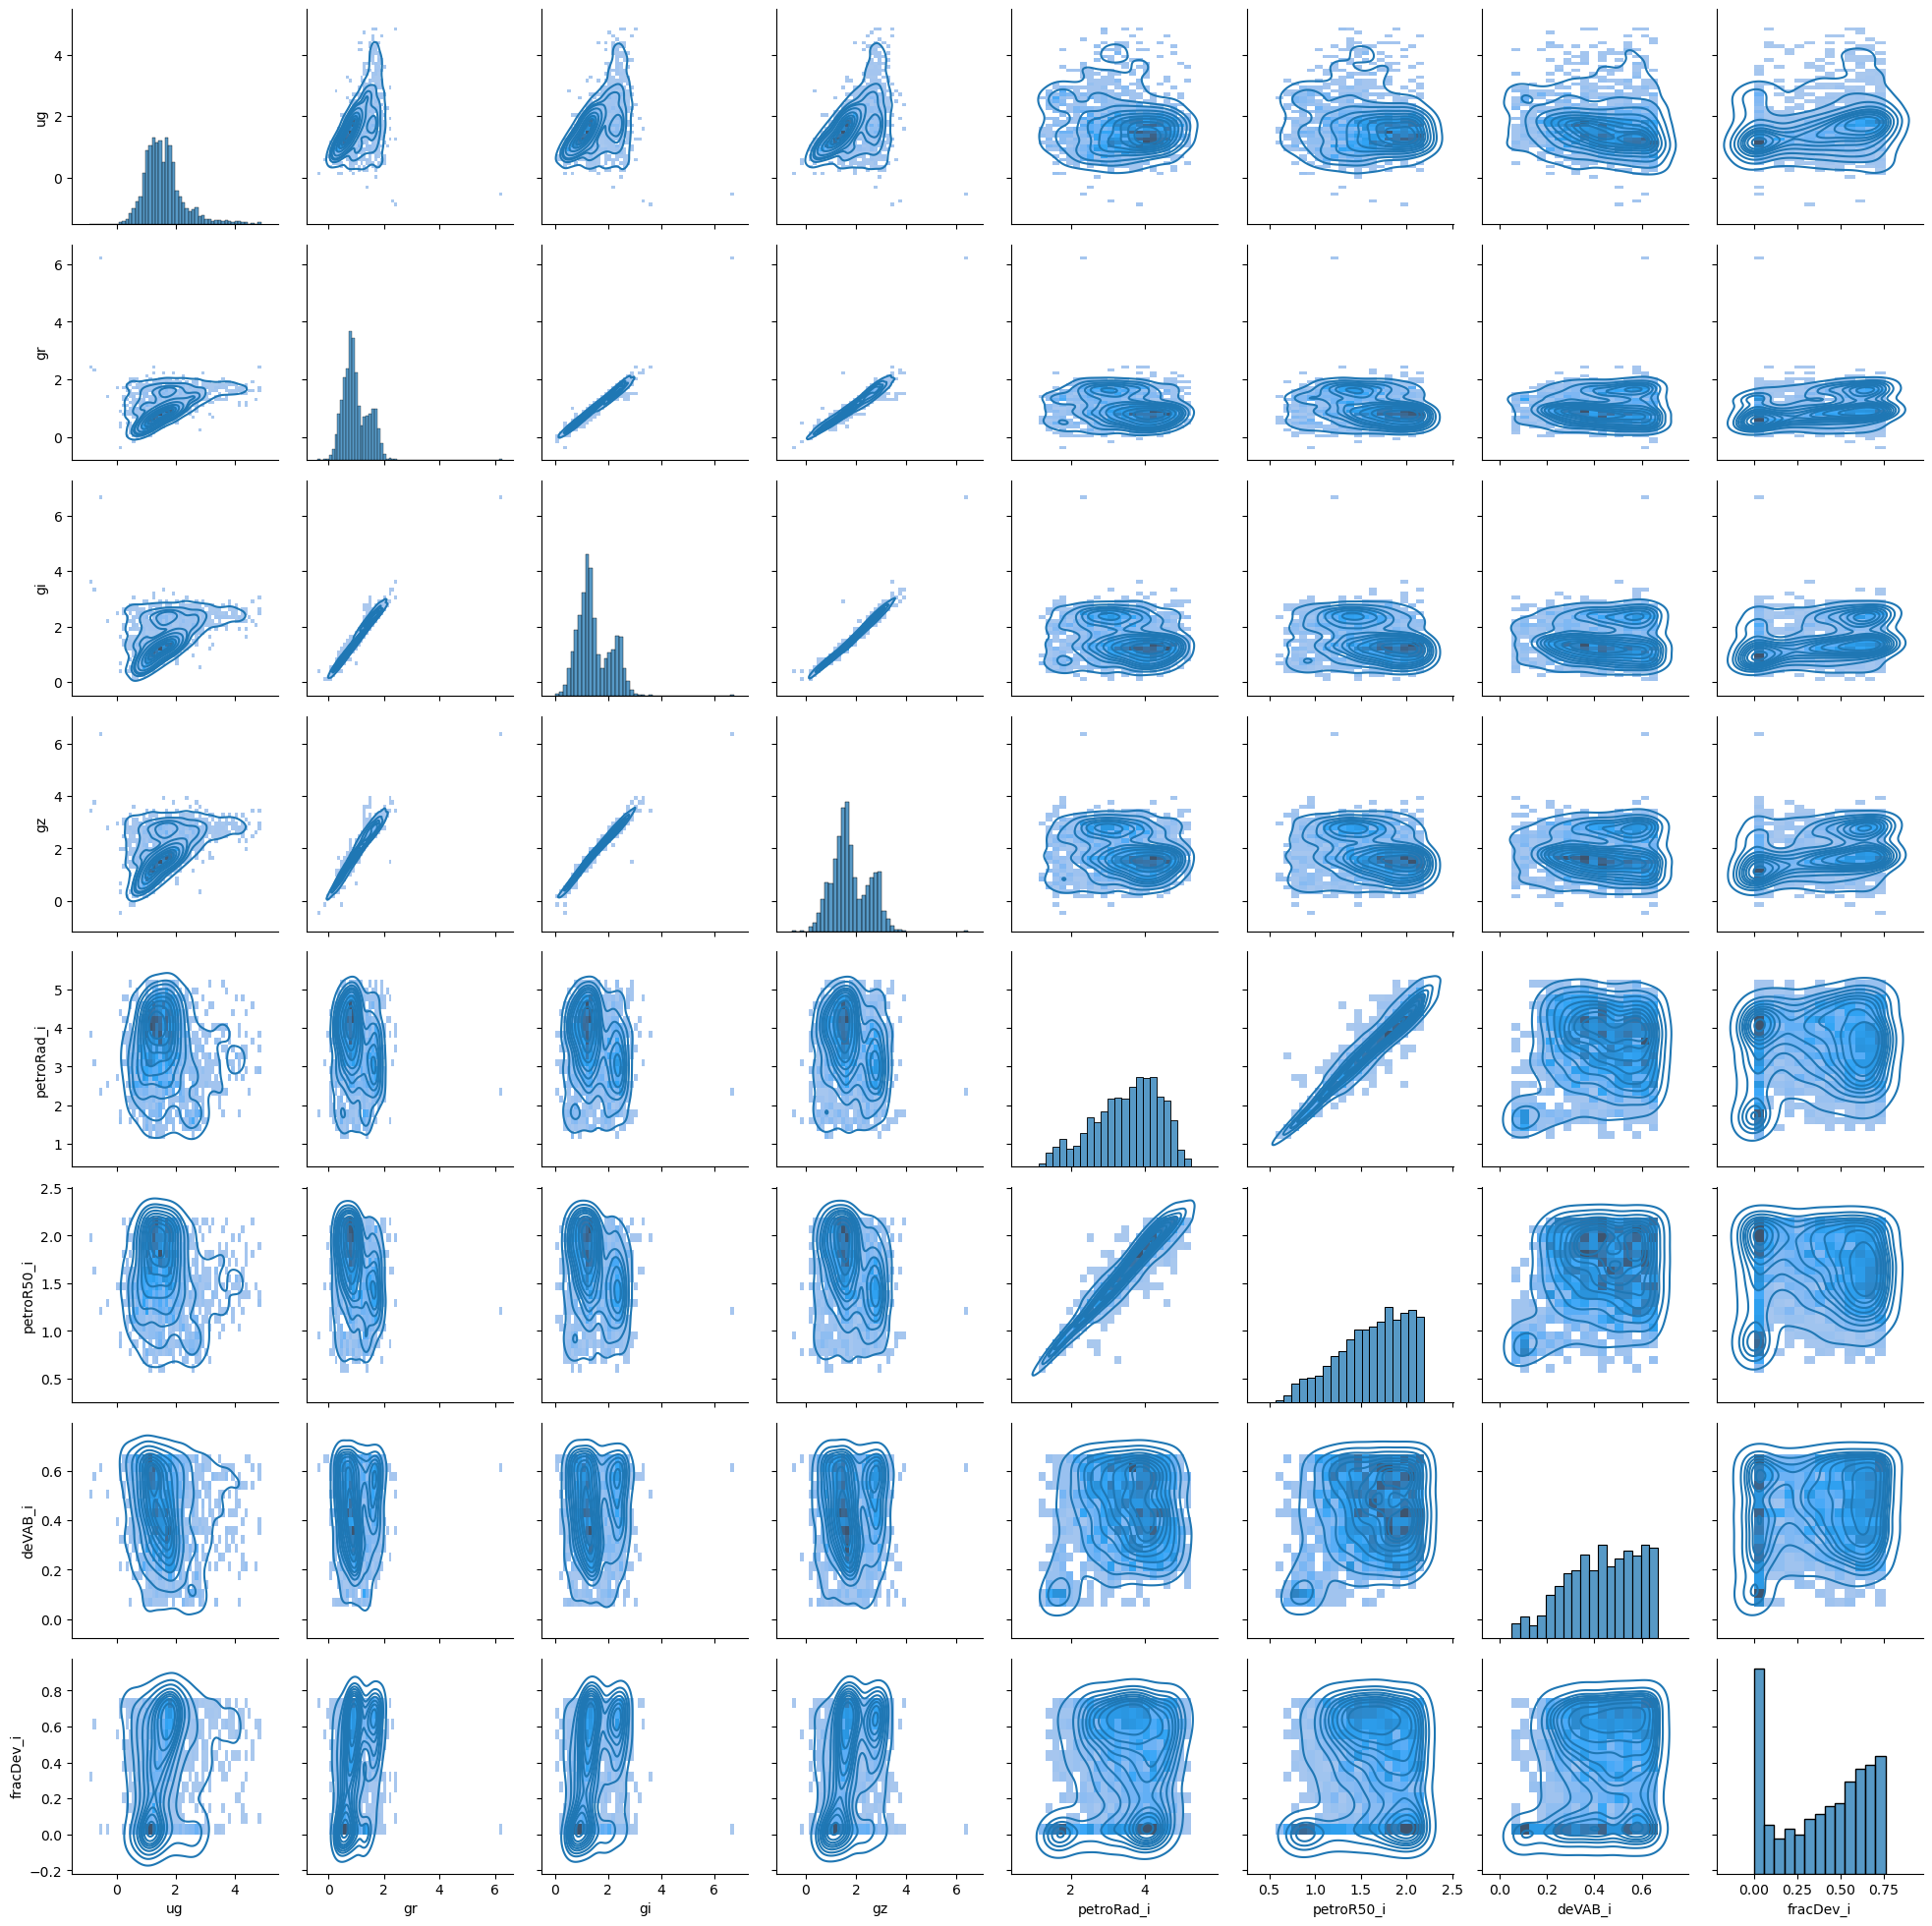

In [518]:
g=sns.PairGrid(sdw)
g.map_diag(sns.histplot)
g.map_offdiag(sns.kdeplot)
g.map_offdiag(sns.histplot)

### 1b - Separating the galaxy types (11 pts) 

Using K-means from `sklearn` with n=3, separate the three clusters of galaxies. Initial guesses, hyper-paramter tuning, dimensionality reduction etc are your choices. What's important is to be able to justify them. To the referee, to me, to yourself. We'll do that in the next part. 

In [519]:
from sklearn.cluster import KMeans
# from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
z = StandardScaler()
Xt = z.fit_transform(sdw)
kmeans = KMeans(n_clusters=3,n_init='auto')
kmeans.fit(Xt)
labels = kmeans.labels_
# color = [f'C{i}' for i in labels]
# scatter(Xt[:,0], Xt[:,1], color=color)
# ax = plt.gca()

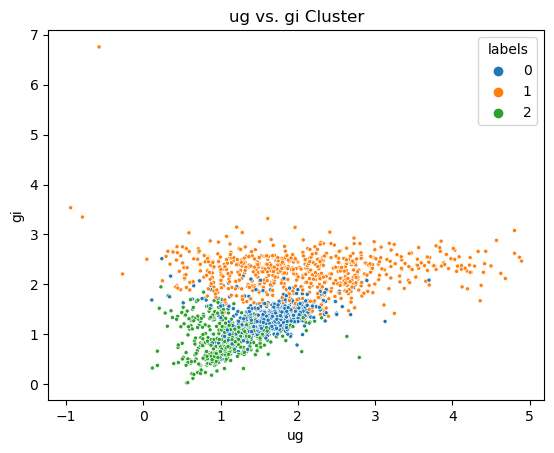

In [576]:
color=[f'C{i}' for i in labels]
sns.scatterplot(data=sdw,x='ug', y='gi', hue='labels',marker='.',palette=sns.color_palette(n_colors=3))
plt.title('ug vs. gi Cluster')
ax = plt.gca()

### 1c - Working with the distributions (11 pts)
Repeat 1a, but using the results of K-means in 1b to create separately colored distributions for your different classes of galaxies. Use the KDE to provide the mean values of each feature and their standard deviation (hint - these are integrals), and compare them to the sample means and standard deviations. 

In [521]:
%matplotlib agg

In [526]:
sdw['labels']=labels
c1=sdw.columns.values
print('Calculated Values:')
print('name  mean  std')
for i in range(len(c1)-1):
    
    kde= sns.kdeplot(sdw,x=c1[i])
        
    kdeline = kde.lines
    # print(kdeline)
    
    xs = kdeline[i].get_xdata()
    # print(xs)
    ys = kdeline[i].get_ydata()
    # print(np.mean(ys))
    
    mean = np.sum(xs[1:]*ys[1:]*(xs[1:]-xs[:-1]))
    std = np.sum(ys[1:]*(xs[1:]-mean)**2 * (xs[1:]-xs[:-1]))
    std = std**0.5
    print(c1[i],mean,std)
    
print('\nSample Values:')
for i in range(len(c1)-1):
    
#     kde= sns.kdeplot(sdw,x=c1[i])
        
#     kdeline = kde.lines
#     # print(kdeline)
    
#     xs = kdeline[i].get_xdata()
#     # print(xs)
#     ys = kdeline[i].get_ydata()
#     # print(np.mean(ys))
    
#     mean = np.sum(xs[1:]*ys[1:]*(xs[1:]-xs[:-1]))
#     std = np.sum(ys[1:]*(xs[1:]-mean)**2 * (xs[1:]-xs[:-1]))
#     std = std**0.5
    mean = np.mean(sdw[c1[i]])
    std = np.std(sdw[c1[i]])
    print(c1[i],mean,std)

/tmp/ipykernel_10783/2763552844.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdw['labels']=labels


Calculated Values:
name  mean  std
ug 1.6060674759264182 0.7235818670443724
gr 0.990790821703131 0.4737513160257761
gi 1.4835571851167821 0.6381422393209571
gz 1.7902676911395934 0.7450034295219572
petroRad_i 3.516221116130571 0.9006358249473273
petroR50_i 1.6293768067919674 0.38444453403541323
deVAB_i 0.43324004353992934 0.15514744921207066
fracDev_i 0.3915103947982641 0.26653795248374057

Sample Values:
ug 1.6060701653941336 0.7074370173635701
gr 0.9907921509578368 0.4631858752991789
gi 1.4835591037992668 0.6239071312344611
gz 1.7902694844042164 0.7283792819202277
petroRad_i 3.5162348244729604 0.8805387906844417
petroR50_i 1.629435622914757 0.37588287363110595
deVAB_i 0.43325643688359305 0.1517045652794311
fracDev_i 0.3914942775516499 0.2607704680262443


In [539]:
sdw['labels']=labels
c1=sdw.columns.values
print('Calculated Values:')
cs ='name  label  mean  std'
cs = cs.split('  ')
for i in range(len(c1)-1):
    
    kde= sns.kdeplot(sdw,x=c1[i],hue='labels')
        
    kdeline = kde.lines
    # print(kdeline)
    for j in range(labels.max()+1):
        xs = kdeline[i*3+j].get_xdata()
        # print(xs)
        ys = kdeline[i*3+j].get_ydata()
        # print(np.mean(ys))

        mean = np.sum(xs[1:]*ys[1:]*(xs[1:]-xs[:-1]))
        std = np.sum(ys[1:]*(xs[1:]-mean)**2 * (xs[1:]-xs[:-1]))
        std = std**0.5
        print(c1[i],j,mean,std)
        
print('\nSample Values:')
for i in range(len(c1)):
    
#     kde= sns.kdeplot(sdw,x=c1[i],hue='labels')
        
#     kdeline = kde.lines
    
    # print(kdeline)
    for j in range(labels.max()+1):
        w1 = sdw.query(f'labels == {j}')
        wog = w1[c1[i]]
#         xs = kdeline[i*3+j].get_xdata()
#         # print(xs)
#         ys = kdeline[i*3+j].get_ydata()
#         # print(np.mean(ys))

#         mean = np.sum(xs[1:]*ys[1:]*(xs[1:]-xs[:-1]))
#         std = np.sum(ys[1:]*(xs[1:]-mean)**2 * (xs[1:]-xs[:-1]))
#         std = std**0.5
        mean = np.mean(wog)
        std = np.std(wog)
        print(c1[i],j,mean,std)

/tmp/ipykernel_10783/1276288262.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdw['labels']=labels


Calculated Values:
ug 0 1.6060674759264182 0.7235818670443724
ug 1 0.990790821703131 0.4737513160257761
ug 2 1.4835571851167821 0.6381422393209571
gr 0 1.7902676911395934 0.7450034295219572
gr 1 3.516221116130571 0.9006358249473273
gr 2 1.6293768067919674 0.38444453403541323
gi 0 0.43324004353992934 0.15514744921207066
gi 1 0.3915103947982641 0.26653795248374057
gi 2 0.3536316109905075 0.47389231380619923
gz 0 0.6330139650080034 0.9665488618922137
gz 1 0.6194168204720345 0.6605490030125603
gz 2 0.18282033709978324 0.2611632926654719
petroRad_i 0 0.4750575853603093 0.6228165094096819
petroRad_i 1 0.33291007601446243 0.3552149708538468
petroRad_i 2 0.2905439530282724 0.39580492001225964
petroR50_i 0 0.692141364019041 0.8954608179105957
petroR50_i 1 0.5008675616437557 0.5273588705952389
petroR50_i 2 0.3500358222417272 0.4879366562667335
deVAB_i 0 0.8191253945222957 1.054792552146061
deVAB_i 1 0.6211021253505338 0.652982241095774
deVAB_i 2 1.0286252028669374 1.351521154247614
fracDev_i 0 0

In [546]:
%matplotlib inline

/tmp/ipykernel_15192/3725654297.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdw['labels']=labels


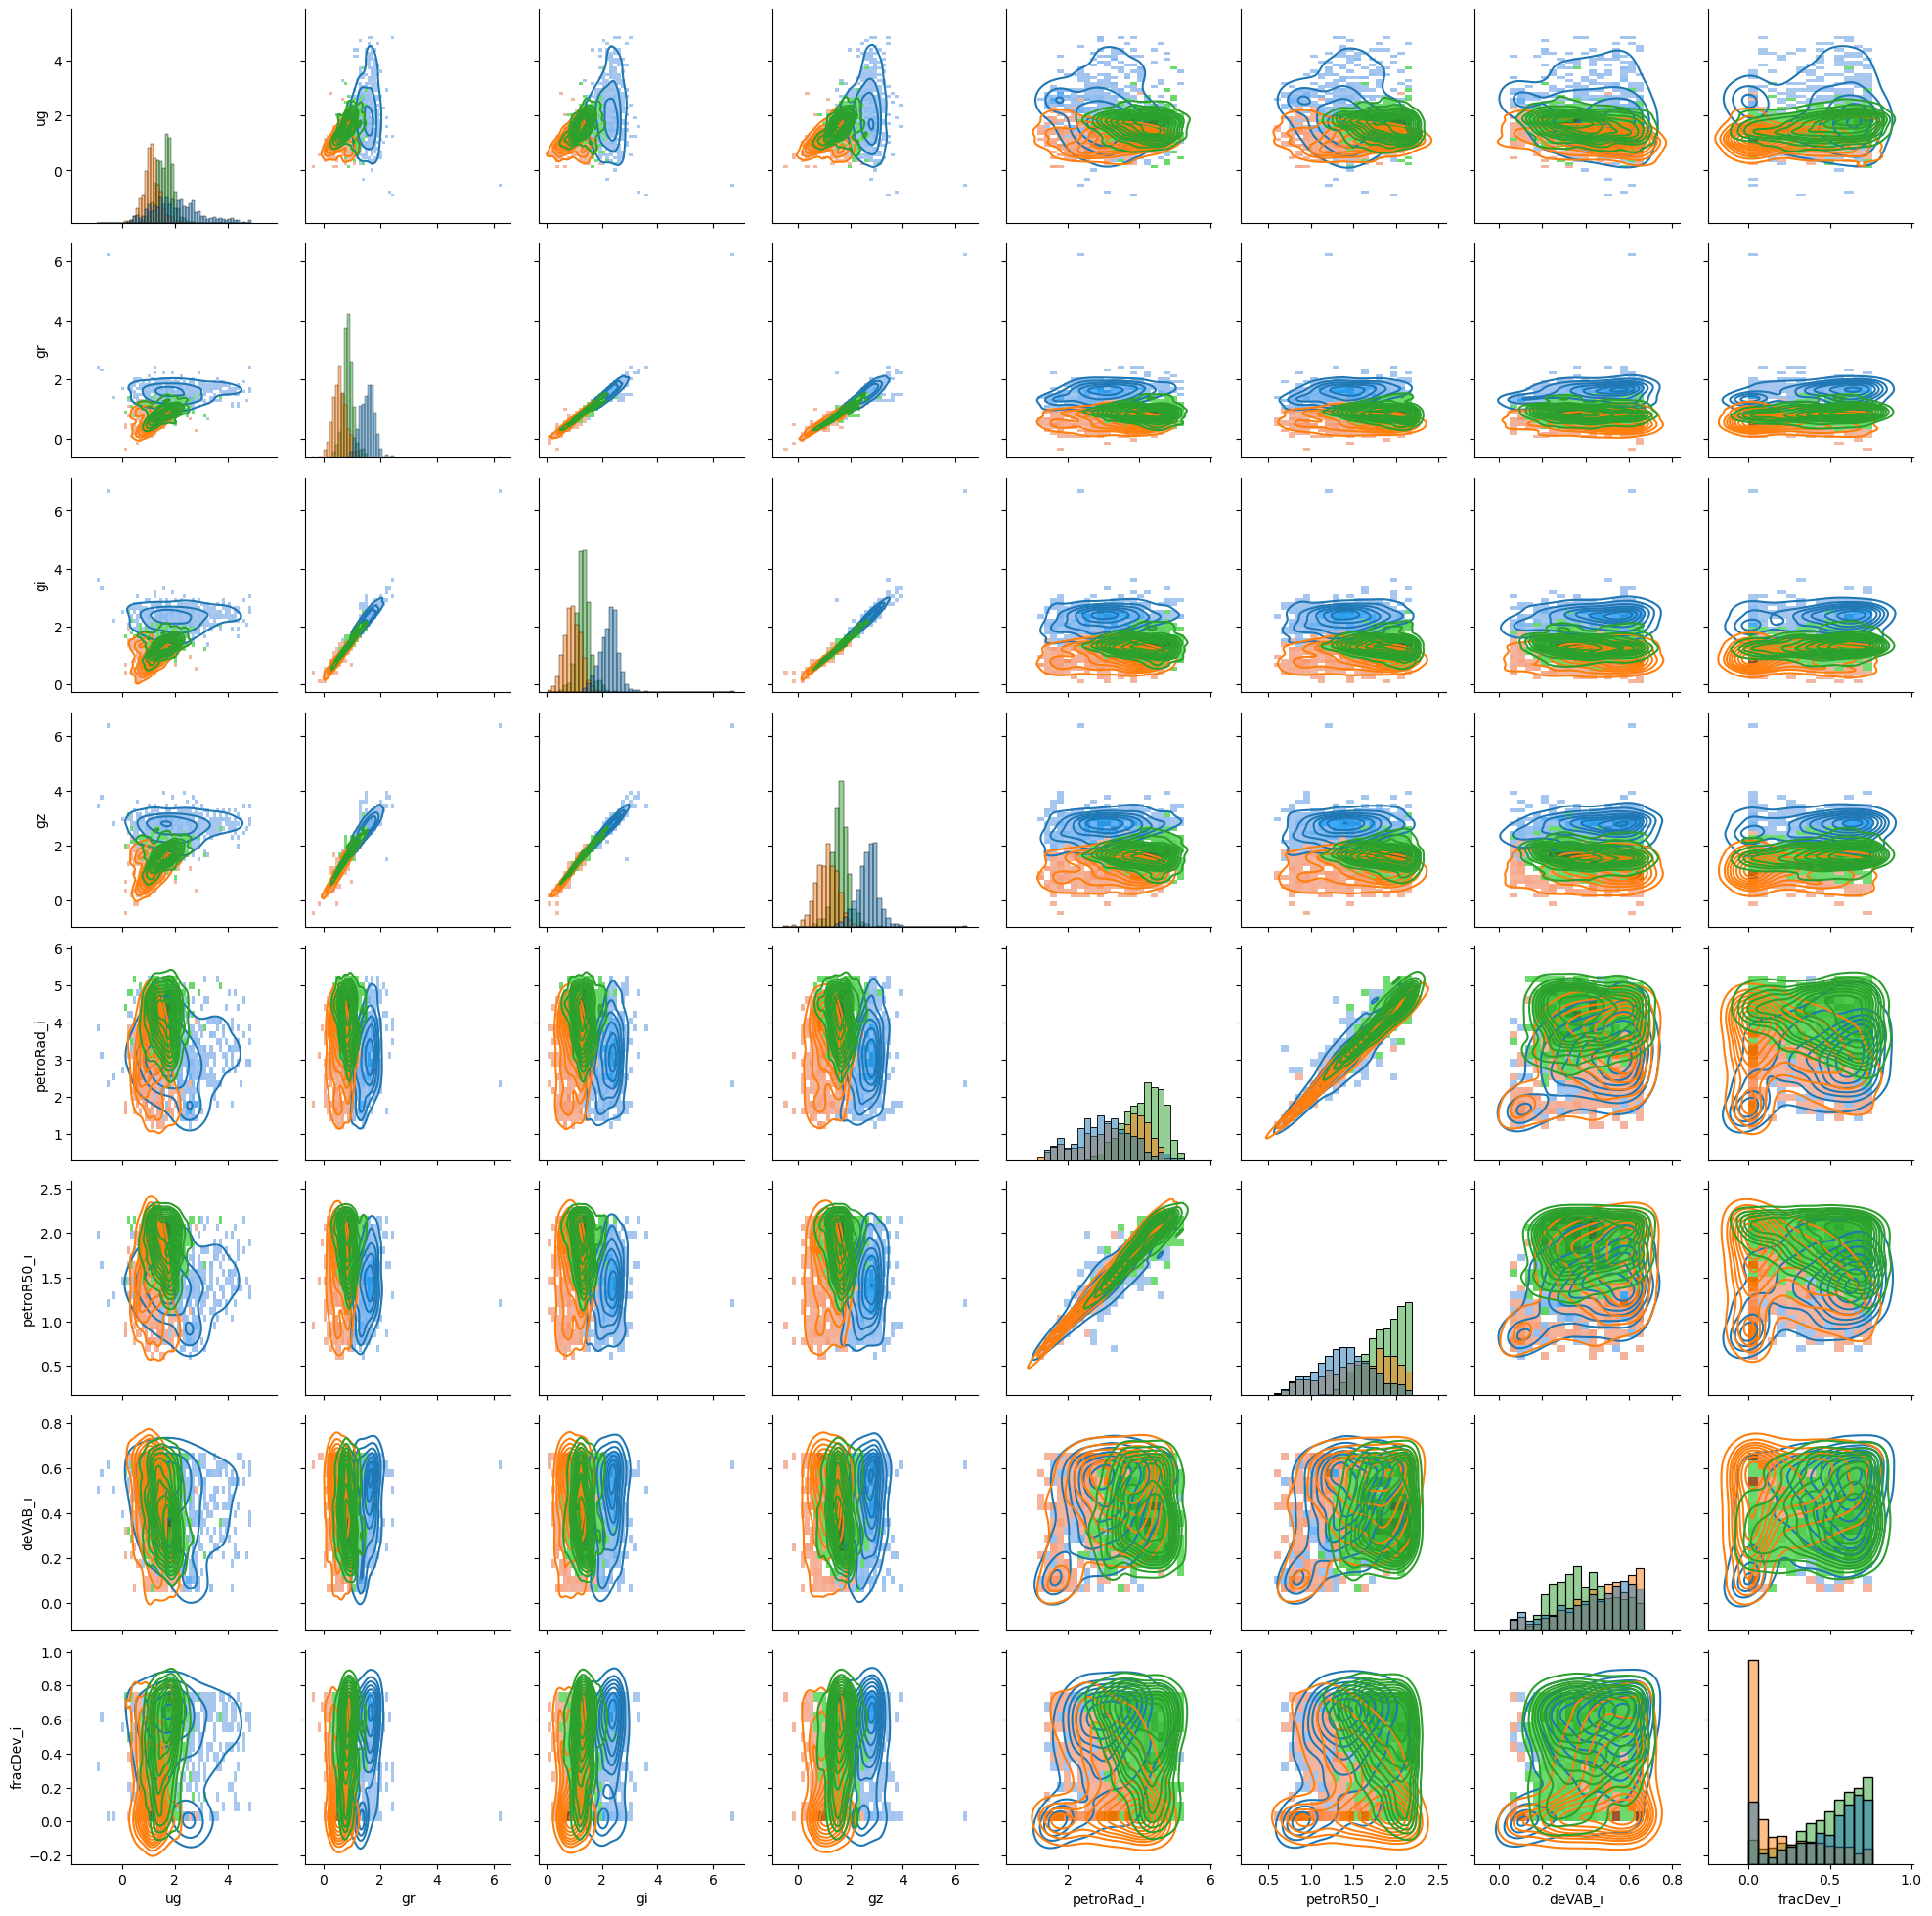

In [121]:

g=sns.PairGrid(sdw,hue='labels',palette=sns.color_palette(n_colors=3))
g.map_diag(sns.histplot)
g.map_offdiag(sns.kdeplot)
g.map_offdiag(sns.histplot)

### Q2. Gaussian Processes + Emcee

There are many sources with periodic light curves that are not strictly sinusoidal. Thus, the use of the cosine kernel (on its own) may not be sufficient to model the signal. The quasi-periodic kernel: 

$$K_{ij} = k(x_i - x_j) = A \exp \left(-\Gamma \sin^2\left[\frac{\pi}{P} \left|x_i - x_j\right|\right]\right)$$

is useful for non-sinusoidal signals. It is implemented in the `george` package. Note that the parameters in the kernel aren't the only parameters you might need... look back on your previous homework assignments and think about what I'm glossing over here. 

I've given you an example light curve file with a decidedly non-sinusoidal, periodic signal from the ASAS-SN project from our colleagues at OSU. 

In [547]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
import corner
from astropy.timeseries import LombScargle
import astropy.units as u
from scipy.signal import find_peaks
import george
from george import kernels
import scipy.stats as stats
import pickle

In [429]:
first = '../../../../first.txt'
full = 'asas_data.dat'
data=pd.read_csv(full,header=0,sep='\s+',skipinitialspace=True,comment='#')
data=data.query('GRADE != "C"').query('GRADE != "D"')
data=data.iloc[::2]
data

HJD   MAG_1   MAG_0   MAG_2   MAG_3   MAG_4  MER_1  MER_0  MER_2  \
0     1869.74854  12.260  12.271  12.226  12.184  12.190  0.030  0.058  0.027   
2     1877.76186  12.222  12.248  12.222  12.246  12.284  0.029  0.050  0.025   
4     1881.72783  11.561  11.549  11.553  11.542  11.538  0.029  0.045  0.025   
6     1885.71965  12.034  12.073  12.038  12.064  12.092  0.030  0.040  0.024   
8     1888.71132  12.174  12.163  12.162  12.181  12.157  0.030  0.052  0.027   
...          ...     ...     ...     ...     ...     ...    ...    ...    ...   
1268  4954.55337  12.174  12.212  12.265  12.306  12.356  0.046  0.046  0.046   
1280  5082.90586  12.088  12.114  12.129  12.117  12.096  0.052  0.050  0.045   
1282  5098.88785  12.248  12.212  12.179  12.133  12.142  0.048  0.044  0.041   
1287  5131.82450  11.830  11.858  11.863  11.879  11.947  0.056  0.048  0.043   
1291  5162.78817  11.888  11.871  11.860  11.871  11.879  0.047  0.046  0.045   

      MER_3  MER_4 GRADE   FRAME  
0     0.031  0.037     A     292  
2     0.029  0.033     A    1539  
4     0.027  0.032     A    2154  
6     0.027  0.031     A    2459  
8     0.030  0.035     A    2935  
...     ...    ...   ...     ...  
1268  0.054  0.060     B  313482  
1280  0.050  0.056     B  325997  
1282  0.046  0.053     A  328055  
1287  0.046  0.050     B  331799  
1291  0.048  0.052     B  334245  

[567 rows x 13 columns]

### 2a - Implement the model  (11 pts)

Examine this data, filter it as you see fit (I've included the file header in full - I'd pick one aperture, and look at the grades and notes about separate datasets). You can make tradeoffs here - more data that is potentially messier, vs less data so weaker constraints, but cleaner. Pick something that you can justify (and if you're struggling at 2c, examine this choice before twiddling with emcee). 

Write down a model for it with the likelihood function, an appropriate prior and posterior.

You may wish to look at the `george` documentation again, particularly how some parameters are better log transformed if the expectation is that they are positive real values. 

https://george.readthedocs.io/en/latest/tutorials/model/

In [430]:
hjd=data[['HJD']].values.flatten()
m2 = data[['MAG_2']].values.flatten()
m2err = data['MER_2'].values.flatten()
avmag=np.mean(data[['MAG_1','MAG_0','MAG_2','MAG_3','MAG_4']].values,axis=1)
averr=np.mean(data[['MER_1','MER_0','MER_2','MER_3','MER_4']].values,axis=1)

In [548]:
def kernel(A, gamma, logP):
    return A * kernels.ExpSine2Kernel(gamma=gamma, log_period=logP)


class mean_model(Model):
    parameter_names = ("m")
    def get_value(self, t):
        
        t = t.flatten()
        mean_model = np.repeat(self.m, len(t))
        return mean_model

bounds = [[10,13]]        
bounds.append([0.01,2]) 
bounds.append([5e1,2e4]) 
bounds.append([0.2,4])    

def log_prior(params):
    for i, bound in enumerate(bounds):
        if params[i] < bound[0] or params[i] > bound[1]:
            return -np.inf
    return 0

def log_posterior(params):
    model.set_parameter_vector(params)
    return model.log_likelihood(m2, quiet=True) + log_prior(params)

### 2b - Initial Guesses (11 pts)

Make some initial guess for the parameters. For the period, use Lomb-Scargle to find the top three periods for this light curve. Initialize 1/3rd of the walkers to each of the top three periods

Do the burn in with `emcee` - a 100 walkers and a 1000 steps should be plenty - you should find that the walkers have migrated away from the starting guess. Plot the chains. 

Make a plot of the log of the Posterior vs the log of the Period - select the periods with the highest log Posterior and change the initial guess for the Period of all the walkers to be in a small region around the Period with the highest log Posterior. 

<Quantity [2.84975088, 2.82530838, 2.80414322] d>

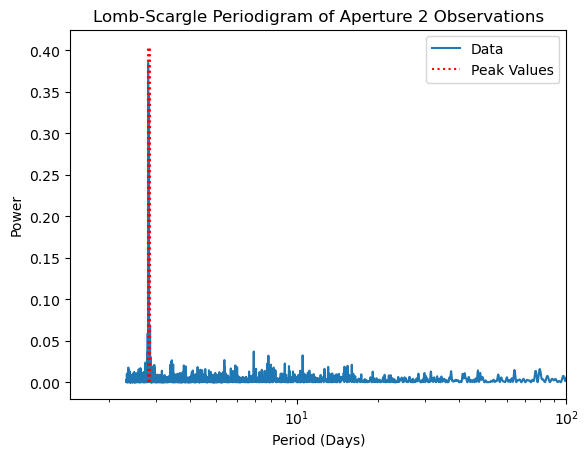

In [553]:

ls =LombScargle(hjd*u.day, m2)
frequency,power=ls.autopower()
p1,oth=find_peaks(power,distance=30,prominence=0.05)
assert len(p1) >=3
top3=frequency[p1[-3:]]**(-1)
t3= top3.value

plt.semilogx(frequency**(-1),power,label='Data')
plt.xlabel('Period (Days)')
plt.ylabel('Power')
plt.title('Lomb-Scargle Periodigram of Aperture 2 Observations')
for fr in p1[-3:]:
    pass
    b=plt.vlines(frequency[fr].value**(-1),1e-7,np.max(power)+.02,zorder=200,color='r',linestyle=':')
b.set_label('Peak Values')   
plt.legend()
plt.xlim(right=1e2)
top3

In [554]:
# initial guesses
ig =[]
ig.append(np.mean(m2))

ig.append(np.std(m2))

ig.append(50_00)

ig.append(np.log(10))
model = george.GP(kernel=kernel(ig[1],ig[2],ig[3]),mean=mean_model(**{'m':np.mean(m2)}))
model.compute(hjd,m2err)

In [443]:
t3= top3.value
nwalkers, ndim = 99, len(model)


p0 = np.zeros((nwalkers,ndim))
p0[:, 0] = abs(stats.norm.rvs(loc=ig[0], scale=3,size=nwalkers))
p0[:, 1] = abs(stats.norm.rvs(loc=ig[1], scale=1,size=nwalkers))
p0[:, 2] = abs(stats.norm.rvs(loc=ig[2], scale=40_000,size=nwalkers))
p0[:33,3] =np.random.normal(loc=np.log(t3[0]), scale=0.05, size=len(p0[:33,2]))
p0[33:66,3]=np.random.normal(loc=np.log(t3[1]), scale=0.05, size=len(p0[:33,2]))
p0[66:,3]=np.random.normal(loc=np.log(t3[2]), scale=0.05, size=len(p0[:33,2]))

# number of samples
nburn = 500
nsamp = 1000
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,pool=pool)
    state = sampler.run_mcmc(p0, nburn, progress=True,)
    sampler.reset()
    
    sampler.run_mcmc(state,nsamp,progress=True);

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [30:51<00:00,  1.85s/it]


In [508]:
with open('samp1.pkl','wb') as fi:
    pickle.dump(sampler,fi)
    fi.close()

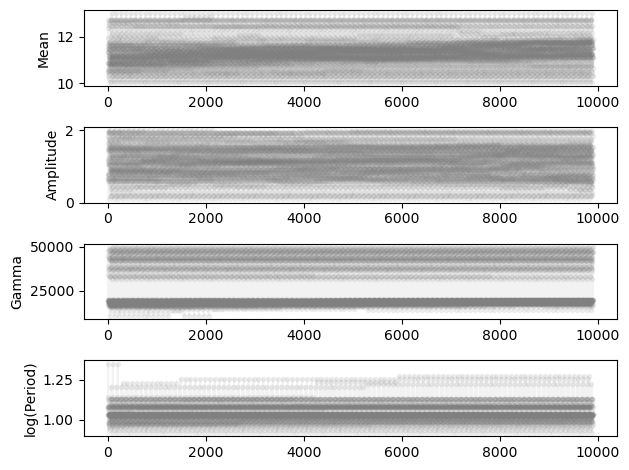

In [468]:
samps0 = sampler.get_chain(flat=True)
prms = ['Mean', "Amplitude", "Gamma", "log(Period)"]
plt.figure(layout='tight')
for i in range(4):
    plt.subplot(411+i)
    plt.plot(samps0[::10,i], linestyle='-', color='grey', marker='.', alpha=0.1)
    plt.ylabel(prms[i])

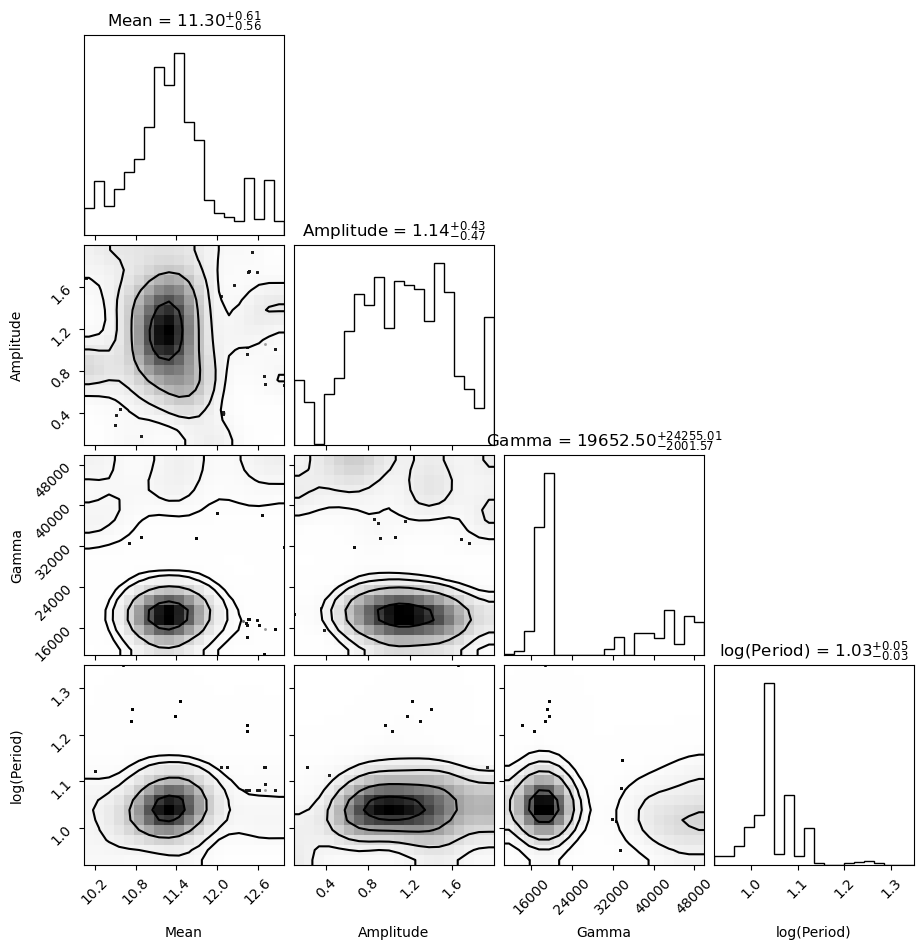

In [445]:
prms = ['Mean', "Amplitude", "Gamma", "log(Period)"]
corner.corner(sampler,plot_contours=True,smooth=2,labels=prms,show_titles=True,);

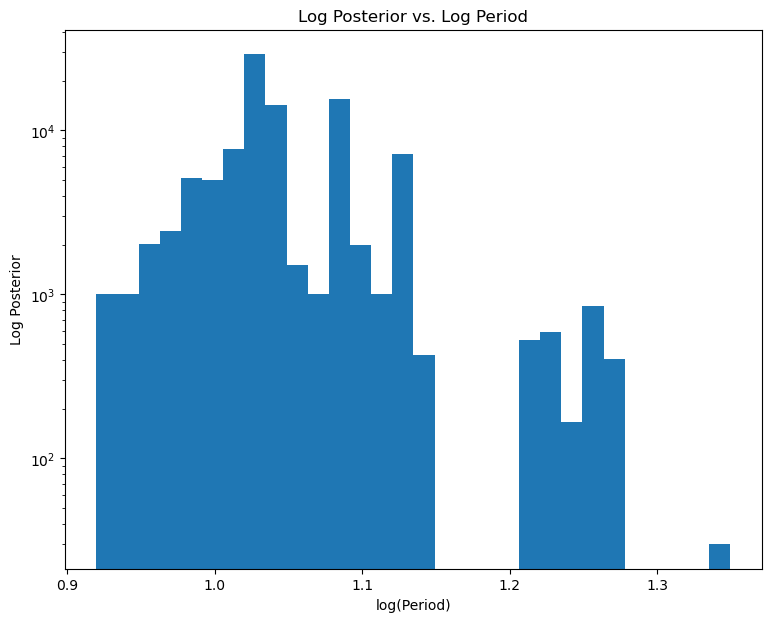

In [557]:
plt.figure(figsize=(9,7))

n,bins,wack=plt.hist(sampler.chain[:,:,3].flatten(),bins=30)
plt.title('Log Posterior vs. Log Period')
plt.ylabel('Log Posterior')
plt.xlabel('log(Period)')
plt.yscale('log')

In [558]:
new_logp=bins[np.argmax(n)]
new_logp

1.019931153017735

In [451]:
p0 = np.zeros((nwalkers,ndim))
p0[:, 0] = abs(stats.norm.rvs(loc=10, scale=3,size=nwalkers))
p0[:, 1] = abs(stats.norm.rvs(loc=0.1, scale=1,size=nwalkers))
p0[:, 2] = abs(stats.norm.rvs(loc=5000, scale=40_000,size=nwalkers))
p0[:,3]= np.random.normal(loc=new_logp, scale=0.05, size=len(p0[:,3]))
# p0[:33,3] =np.random.normal(loc=np.log(t3[0]), scale=0.05, size=len(p0[:33,2]))
# p0[33:66,3]=np.random.normal(loc=np.log(t3[1]), scale=0.05, size=len(p0[:33,2]))
# p0[66:,3]=np.random.normal(loc=np.log(t3[2]), scale=0.05, size=len(p0[:33,2]))

# number of samples
nburn = 500
nsamp = 1000
with Pool() as pool:
    sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,pool=pool)
    state = sampler2.run_mcmc(p0, nburn, progress=True,)
    sampler2.reset()
    sampler2.run_mcmc(state,nsamp,progress=True);

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [31:04<00:00,  1.86s/it]


In [511]:
with open('samp2.pkl','wb') as fi:
    pickle.dump(sampler2,fi)
    fi.close()

### 2c - Infer the model parameters (11 pts)

Plot the chains, the corner plot, the folded lightcurve, the Gaussian process model given the median parameters, 10 other draws from the model and the uncertainty about the model. 


In [452]:
samps= sampler2.get_chain(flat=True)

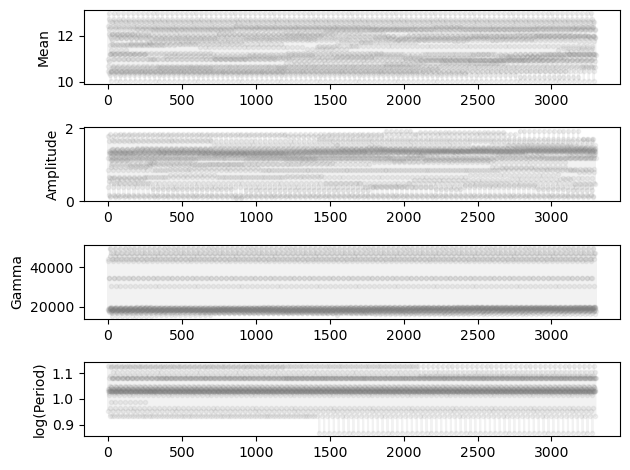

In [469]:
plt.figure(layout='tight')
prms = ['Mean', "Amplitude", "Gamma", "log(Period)"]
for i in range(4):
    plt.subplot(411+i)
    plt.plot(samps[::30,i], linestyle='-', color='grey', marker='.', alpha=0.1)
    plt.ylabel(prms[i])

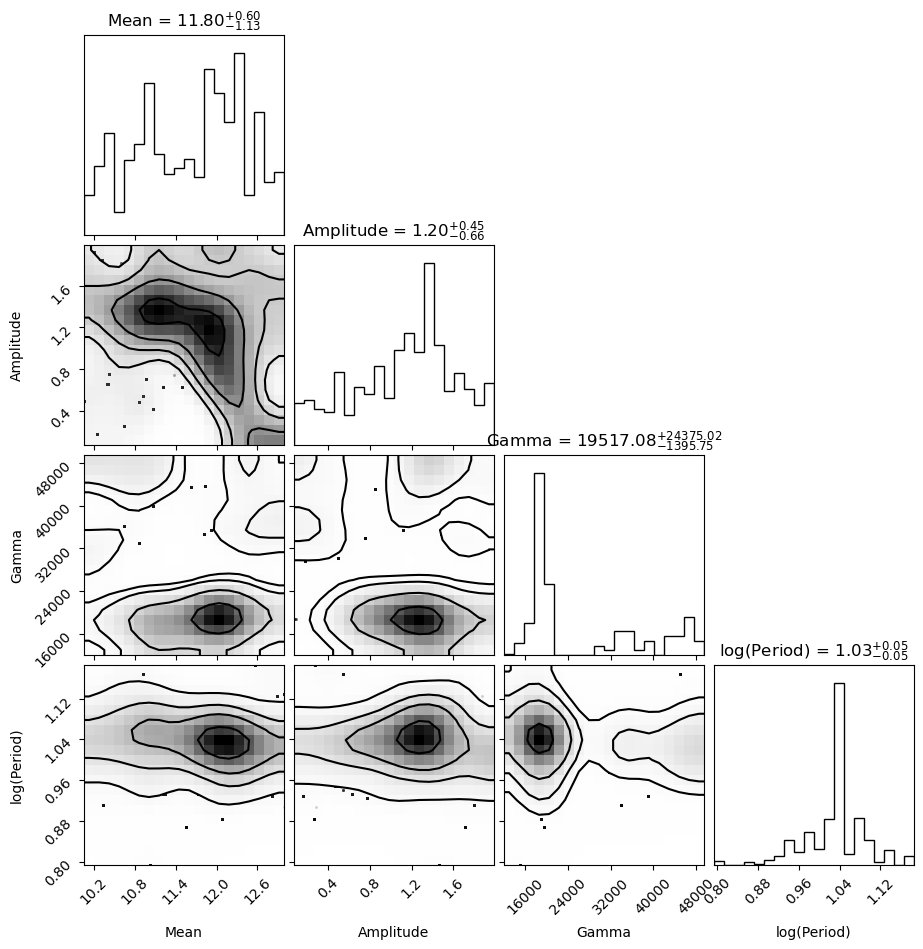

In [454]:
prms = ['Mean', "Amplitude", "Gamma", "log(Period)"]
corner.corner(sampler2,plot_contours=True,smooth=2,labels=prms,show_titles=True,);

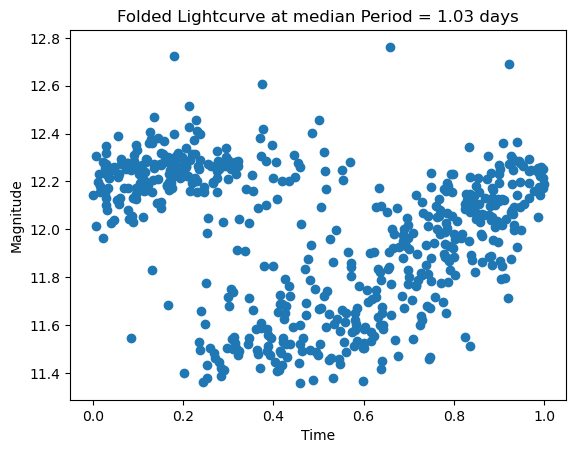

In [573]:
ser = np.argsort(hjd)
srb = hjd[ser]
med = np.median(samps[:,3])
xtime=((hjd- hjd.min())%np.exp(med))/np.exp(med)
plt.title(f'Folded Lightcurve at median Period = {med:0.2f} days')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.scatter(xtime,m2);

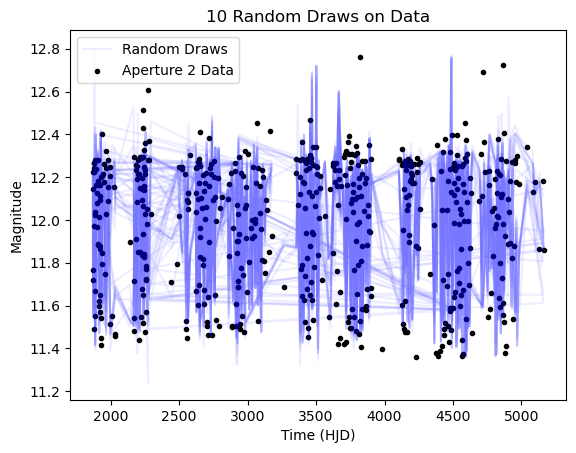

In [561]:
draws = np.random.randint(0,len(samps[:,3]),size=10)
ser = np.argsort(hjd)
srb = hjd[ser]
for draw in draws:
    model = george.GP(mean=lightcurve_model(samps[draw][0]), kernel=kernel(*samps[draw][1:]))
    model.compute(srb, m2err[ser])
    mgp=model.predict(m2,hjd,return_cov=False,)
    b=plt.plot(hjd,mgp,"b-",alpha=0.07)
b[0].set_label('Random Draws')
plt.title('10 Random Draws on Data')
plt.xlabel('Time (HJD)')
plt.ylabel('Magnitude')
plt.scatter(hjd,m2,c='k',marker='.',label='Aperture 2 Data')
plt.legend(loc='best');

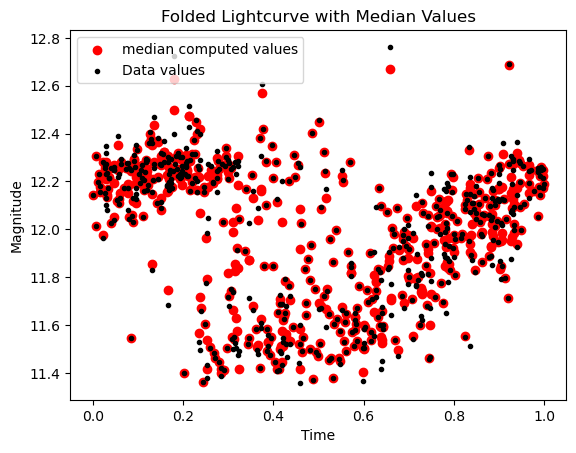

In [563]:
draws = np.random.randint(0,len(samps[:,3]),size=10)
medv = np.median(samps,axis=0)
# for draw in draws:
model = george.GP(mean=lightcurve_model(medv[0]), kernel=kernel(*medv[1:]))
model.compute(hjd, m2err)
mgp=model.predict(m2,hjd,return_cov=False,)
plt.scatter(xtime,mgp,c="r",label='median computed values')
plt.scatter(xtime,m2,c='k',marker='.',label='Data values')
plt.title('Folded Lightcurve with Median Values')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend(loc='best');

N.B. you should be a bit worried about "burn in" and how the walkers were initialized throughout. If you plan to use GPs to search for periods in your own work, I highly recommend you read Angus et al. 2018 on the GP periodogram. Angus et al. provide far more intelligent methods for initializing the MCMC than what is presented here. 

### Q3: PyMC (yes, that thing), hierarchical mixture models, and the mass-radius relation for small exoplanets

The mass-radius relation is a relationship between the radius $R$ of an exoplanet and its mass $M$. We usually call planets smaller than the Neptune size $(R < 4 R_{\oplus})$ small planets. In the Solar System, we don't have any planets between the Earth and Neptune sizes ($ 1-4 R_{\oplus}$), whereas in extrasolar systems, plenty of planets with radii in the range are observed. Thus, it's extremely intriguing to study the compositions of these planets and understand why we don't have one in the Solar System.

In this problem, you will work on one of the papers that one of our colloquium speakers brought up (this is why you should go to colloquium btw, because it'd have totally helped with this final exam to know the answer) - the mass-radius relation for small exoplanets around M-dwarfs. 

The paper is by [Luque et al., Science 377, 1211 (2022)](https://ui.adsabs.harvard.edu/abs/2022arXiv220903871L/abstract). We will reproduce some of their results using the PyMC.

In [565]:
## Download the dataset from Luque et al. 2022
data = pd.read_csv("https://carmenes.caha.es/ext/tmp/TMP.csv")
data.head()

ID  ID_Star      Star          AltName       Karmn     RA_J2000  \
0   1        1   GJ 3053         LHS 1140  J00449-152  00:44:59.33   
1   2        1   GJ 3053         LHS 1140  J00449-152  00:44:59.33   
2   3        2  TOI-1468  LSPM J0106+1913  J01066+192  01:06:36.98   
3   4        2  TOI-1468  LSPM J0106+1913  J01066+192  01:06:36.98   
4   5        3   GJ 3090          TOI-177         NaN  01:21:45.39   

      DE_J2000     SpT  SpTnum    d_pc  ...  eurho_gcm-3  edrho_gcm-3  Teq_K  \
0  -15:16:17.5  M4.5 V     4.5  14.964  ...         0.84         0.80  378.9   
1  -15:16:17.5  M4.5 V     4.5  14.964  ...         0.81         0.74  708.9   
2  +19:13:33.2    M3 V     3.0  24.721  ...         1.05         0.92  682.2   
3  +19:13:33.2    M3 V     3.0  24.721  ...         0.21         0.19  337.5   
4  -46:42:51.8    M2 V     2.0  22.454  ...         0.52         0.45  693.0   

   euTeq_K  edTeq_K     TSM   ESM  Method  DiscoveryRef       ParameterRef  
0      4.3      4.2    8.88  0.19      RV         Dit17  Dit17 Men19 Lil20  
1      8.0      7.8   25.90  3.45      RV         Dit17  Dit17 Men19 Lil20  
2      7.4      6.9    9.00  6.30      RV         Cha22              Cha22  
3      3.7      3.4   59.00   NaN      RV         Cha22              Cha22  
4     18.0     18.0  221.00   NaN      RV        Alm22a             Alm22a  

[5 rows x 44 columns]

In [566]:
## Lets extract mass and radius and their uncertainties from the data; both M and R are in Earth units 
M = data.M_Mterra
R = data.R_Rterra

err_M = (data.edM_Mterra+data.euM_Mterra)/2  # Assume the + and - errors on M and R are symmetric because lazy
err_R = (data.edR_Rterra+data.euR_Rterra)/2

ind = err_R < 1.
M = M[ind]
R = R[ind]
err_M = err_M[ind]
err_R = err_R[ind]

c=data['rho_gcm-3'][ind]

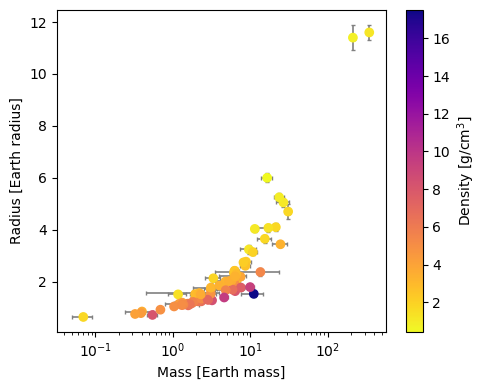

In [567]:
## Plot the mass and radius of small planets around M-dwarfs
plt.figure(figsize=(5,4))
plt.errorbar(M, R, xerr=err_M, yerr=err_R,
             linestyle='', fmt='o', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(M, R, c=c, zorder=100, cmap='plasma_r')
plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.colorbar(label=r'Density [g/cm$^3$]')
plt.tight_layout()
plt.show()

Exoplaneteers made up cute names to describe planets in different compositions.
- "Rocky world" if a planet has a bulk density similar to the Earth.
- "Water world" if a planet has a bulk density consistent with 50% rocky and 50% water ice.
- "Puffy world" if a planet has a bulk density smaller than the "Water World" density.

Now, while it's possible that this final is making you wish you were on a "puff" of something or the other, we'll restrict our analysis to the rocky and water worlds. It's where the grant dollars are. 


### 3a - modeling the mass radius relation for rocky worlds (11 pts) 

First, select the rocky worlds. 

Let's write down the mass-radius relation for rocky worlds as a power law.

$R = aM^b$, where $a$ is proportional to $1/\rho_{\oplus}$, and $b$ is unitless. If the relation follows $M = \frac{4}{3}\pi R^3 \rho$, we have $a = 1$ and $b = 1/3$. However, in reality, the interior density of planets is not uniform and depends on the equation of state.

Build a PyMC model to find parameters of interest {a, b}. Plot the traces (`pm` has a `plot_trace` function)and inferred model, along with some draws.

Hints:
- As a, b have to be positive, I'd suggest Uniform priors on log a, log b, and then using pm.Deterministic to exponentiate them 
- For the masses, since you've selected the rocky worlds, I'd suggest a normal distribution with the sample mean and sample standard deviation of the rocky worlds. 
- Given M, a, b you can use pm.Deterministic to get R_model
- Assume our favorite normal likelihood for R_model. You have the observed radius and their uncertainties from the file.

In [568]:
rocky=c.values>5.51
MR = M.values[rocky]

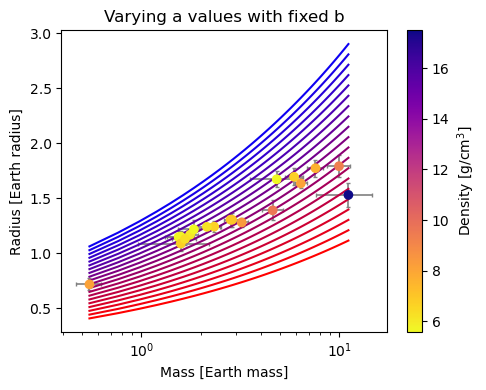

In [570]:
def mod1(a,b,m):
    return a*m**b
ex1= np.linspace(MR.min(),MR.max(),50)
av = np.linspace(0.5,1.3,20)
okay=[mod1(val,1/3,ex1) for val in av]

plt.figure(figsize=(5,4))
plt.errorbar(MR, R.values[rocky], xerr=err_M.values[rocky], yerr=err_R.values[rocky],
             linestyle='', fmt='o', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(MR, R.iloc[rocky], c=c.iloc[rocky], zorder=100, cmap='plasma_r')
plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.colorbar(label=r'Density [g/cm$^3$]')

for i in range(len(okay)):
    plt.plot(ex1,okay[i],c=(1-i/len(okay),0,(i/len(okay))))
    
# plt.scatter(1,1,c='green',zorder=200)
plt.title('Varying a values with fixed b')
plt.tight_layout()
plt.show()

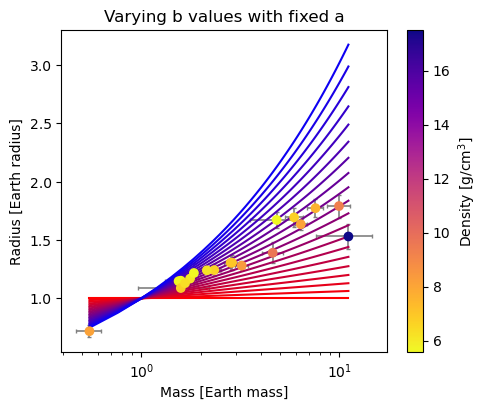

In [571]:
def mod1(a,b,m):
    return a*m**b
ex1= np.linspace(MR.min(),MR.max(),50)
bv = np.linspace(0,2.4/5,20)
okay2=[mod1(1,val,ex1) for val in bv]

plt.figure(figsize=(5,4))
plt.errorbar(MR, R.values[rocky], xerr=err_M.values[rocky], yerr=err_R.values[rocky],
             linestyle='', fmt='o', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(MR, R.iloc[rocky], c=c.iloc[rocky], zorder=100, cmap='plasma_r')
plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.colorbar(label=r'Density [g/cm$^3$]')

for i in range(len(okay2)):
    plt.plot(ex1,okay2[i],c=(1-i/len(okay2),0,(i/len(okay2))))
plt.tight_layout()
plt.title('Varying b values with fixed a')
plt.show()

In [152]:
import pymc as pm

In [153]:

bm= pm.Model()

with bm:
    a = pm.Uniform('a',lower=0.5,upper=1.5)
    b = pm.Uniform('b',lower=0,upper=2.4/5)
    mu = a*MR**b
    robs = pm.Normal('robs',mu=mu,observed=R.values[rocky],sigma=err_R.values[rocky])
    trace=pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


<Figure size 640x480 with 0 Axes>

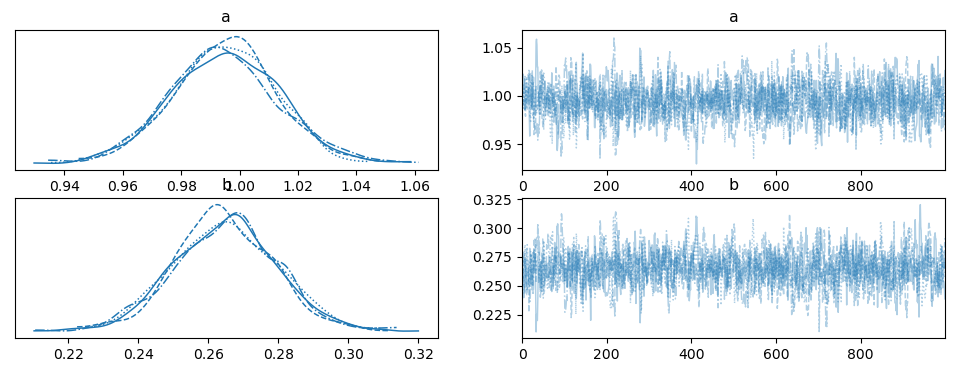

In [154]:
# import arviz as az
plt.figure(layout='tight')
pm.plot_trace(trace);

### 100 Random Draws

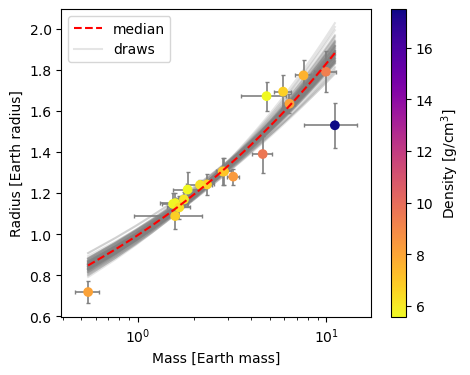

In [155]:
rog1=np.median(trace.posterior['a'])
rog2=np.median(trace.posterior['b'])
dri = np.random.randint(0,high=np.ravel(trace.posterior['a']).size,size=100)
draw1= np.ravel(trace.posterior['a'])[dri]
draw2=np.ravel(trace.posterior['b'])[dri]

plt.figure(figsize=(5,4))
plt.errorbar(MR, R.values[rocky], xerr=err_M.values[rocky], yerr=err_R.values[rocky],
             linestyle='', fmt='o', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(MR, R.iloc[rocky], c=c.iloc[rocky], zorder=100, cmap='plasma_r')
plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.colorbar(label=r'Density [g/cm$^3$]')
plt.plot(ex1,mod1(rog1,rog2,ex1),zorder=200,c='red',linestyle='--',label='median')
for i in range(draw1.size):
    bruh=plt.plot(ex1,mod1(draw1[i],draw2[i],ex1),alpha=0.2,c='grey')
bruh[-1].set_label('draws')
plt.legend(loc='best');

### 3b - The Mass-Radius Relation for Rocky+Water Worlds (23 pts) 

Let's now add water worlds and model the mass-radius relation for both rocky and water worlds. Physically, it will require two models to describe the mass-radius relations for rocky and water worlds. The tricky part is we don't know exactly which kind of worlds a planet is belong to. In this situation, it is helpful to introduce a categorical variable `z` that is either 0 or 1, with the relative posterior probabilities telling us how Rocky/Watery a planet is.

Select the Rocky Water worlds - see the categories above 3a again. 

To make this work like magic with PyMC and it's Monte-Carlo sampler, we can choose a special prior for our categorial variable: the Drichlet Prior - https://en.wikipedia.org/wiki/Dirichlet_distribution
```python
    # Two categories for water and rocky worlds
    p = pm.Dirichlet("p", a=np.ones(2), shape=2)
    z = pm.Categorical("z", p=p, shape=len(RockyWaterWorlds))
```

The rest of the PyMC model should be the same as 3a except you are fitting two relations - one for rocky worlds and one for water worlds, so you need two different `a` and `b` parameters - `shape=2` as above should take it. You might want to sort the `a` parameter with `transform=pm.distributions.transforms.ordered` when you define the prior to sort things. 

Build a PyMC model to find parameters of interest {a, b}. Plot the traces (`pm` has a `plot_trace` function)and inferred model, along with some draws.

---

For my cut of water worlds from the data I am using estimates from the figure in the paper referenced above,

![](https://lh3.googleusercontent.com/PMKUgBQM5JuQJ85BHzvDLqnMAwgbBD815npVRgC054OGSYGUa6jYw-P9mt_dABLF65bGDimxCvfTPBN0AOaTTEDcAnRGZo2CpqYeolwLzlLl9A7Z_54fnvGj611byun8RD9mQ5JWsyNLU89sWXjJmknJbDMjgG0NknHye-pBt9cYj_LvglE-n5-fhkQFXcF0RopVyBLX8szt4SizhR5ZzzxizpL36dNdJkRNu8wlDUPQ3PEd66InH6x6vKJ7s0UyO2ECjkHTLB_RGSB_jf8g7x92OO3OJpW4H5tOZK8_vNDNvPv_r1TlBxC6KqeXNLBZqBMthNwrtjqYGxAeLdWTIqam_RiWPNKMe5KlCoVBAz61-divI2RahcwE1NCsG_mMxicxm1JNVVeVzTVvTaXHuZIHqopmpz_bMaH2jQ62mKI3nIPqNkNZhPhCJ5isWGOBjY0colw7Z_MpObnxYtrhnFN08X8my28xKv4pSY2EPHNj3By-tHxuan8yPrJTtPce9CgDFyc05ws509LytW6gwS4uFLvB5vGIuFsoD_98PfW1mkrKNkXkrH3LREbH7GC-gLdBTv-5nDDlcGvIzRAScGsN7gutakPEB8dMa0miyw478NelBOfS411AL2ehIFRzjmg6IU4kEHgASsCR9-hBh2U82FliDao85KXNXzn8EBsXDhSWLTJlUiWuQlQKc315r3BUq5AsIE7v4_hX8aE_M4tDvgqshGA_qcweRQkHeo__9A30SfvP0dLTt7mcy8g7vVeuwMAJKUjVbbWXQ1rtNiylXTpypUcveu92Nszq8NSEEuCw7bN-B68ZB39Invo3wR75I_4nnHEFd4NejCtLwOMUHNeHjUGHWTemkskxcIKsI_Gn1iluhQMyoiMYV1Ed3056eZw-xf7DBhjxKbj1P7Oi5jIPh_AuwBbFKpYomQIk=w925-h624-s-no?authuser=0)

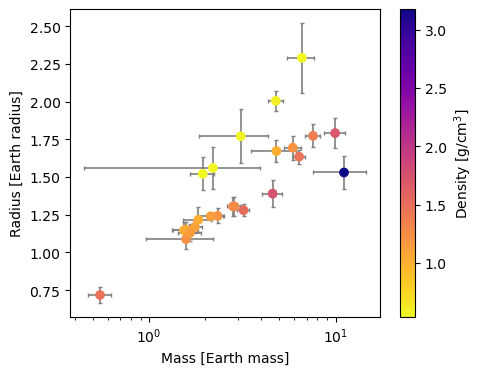

In [156]:
water=(c.values/5.51 > 0.5) & (c.values/5.51 < 0.6) & (R.values < 2.5) & (R.values > 1.5)
rockywater = water | rocky
MRW = M.values[rockywater]


plt.figure(figsize=(5,4))
plt.errorbar(MRW, R.values[rockywater], xerr=err_M.values[rockywater], yerr=err_R.values[rockywater],
             linestyle='', fmt='o', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(MRW, R.iloc[rockywater], c=c.iloc[rockywater]/5.51, zorder=100, cmap='plasma_r')

plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.colorbar(label=r'Density [g/cm$^3$]')

In [158]:
bm= pm.Model()

with bm:
        # Two categories for water and rocky worlds
    p = pm.Dirichlet("p", a=np.ones(2), shape=2)
    z = pm.Categorical("z", p=p, shape=int(np.sum(rockywater)))
    a = pm.Uniform('a',lower=0.5,upper=1.5,shape=2)
    b = pm.Uniform('b',lower=0,upper=2.4/5,shape=2)
    one = (a[0]*MRW**b[0]) * (1-z)
    two = a[1]*MRW**b[1] * (z)
    mu = one+two
    robs = pm.Normal('robs',mu=mu,observed=R.values[rockywater],sigma=err_R.values[rockywater])
    trace1=pm.sample(1000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p, a, b]
>BinaryGibbsMetropolis: [z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
/home/berres2002/miniconda3/envs/fds/lib/python3.10/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


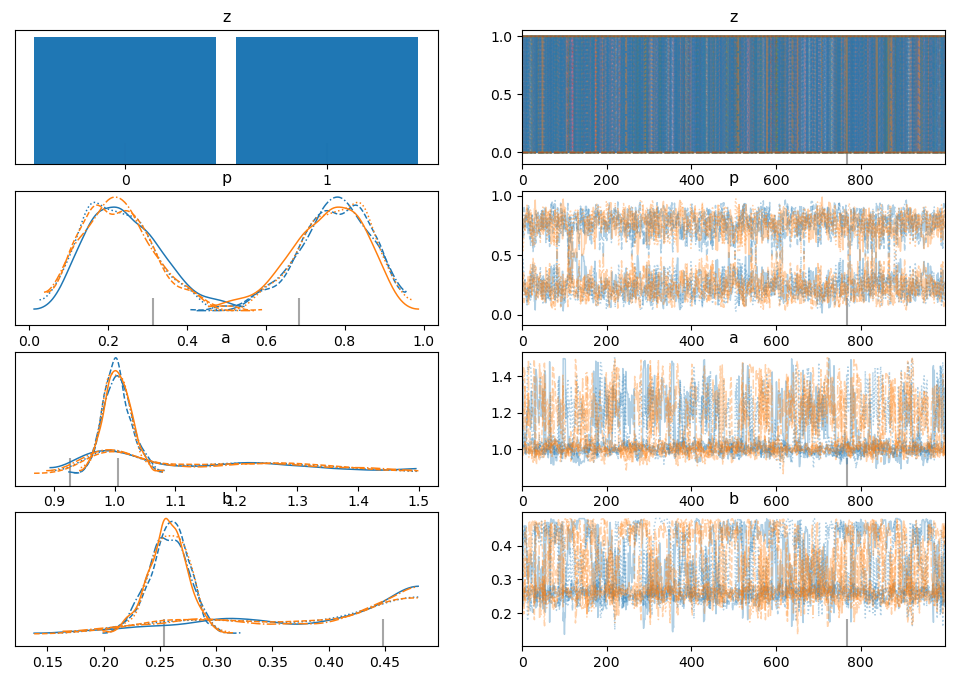

In [159]:
pm.plot_trace(trace1);

### 100 Random Draws Part 2

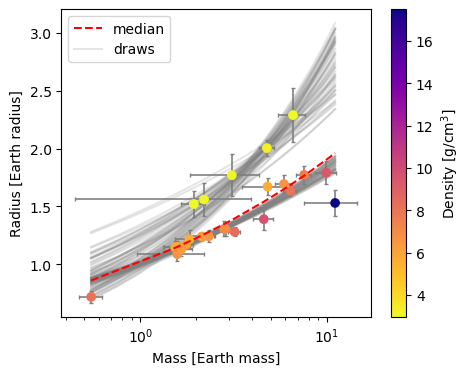

In [160]:
a1=trace1.to_dict()['posterior']['a']
b1=trace1.to_dict()['posterior']['b']

rog1=np.median(a1)
rog2=np.median(b1)
dri = np.random.randint(0,high=np.ravel(trace1.posterior['a']).size,size=100)
draw1= np.ravel(trace1.posterior['a'])[dri]
draw2=np.ravel(trace1.posterior['b'])[dri]

ex2= np.linspace(MRW.min(),MRW.max(),50)

plt.figure(figsize=(5,4))
plt.errorbar(MRW, R.values[rockywater], xerr=err_M.values[rockywater], yerr=err_R.values[rockywater],
             linestyle='', fmt='o', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(MRW, R.iloc[rockywater], c=c.iloc[rockywater], zorder=100, cmap='plasma_r')

# ex2= np.linspace(,50)
plt.plot(np.sort(MRW),mod1(rog1,rog2,np.sort(MRW)),zorder=200,c='red',linestyle='--',label='median')
for i in range(draw1.size):
    bruh=plt.plot(ex1,mod1(draw1[i],draw2[i],ex2),alpha=0.2,c='grey')
bruh[-1].set_label('draws')
# plt.scatter(MRW.max(),3.5)
plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.legend()
plt.colorbar(label=r'Density [g/cm$^3$]');



### Throughout, make sure your plots have things like appropriate axes scales, axes labels, errorsbars, legends, reasonable colors. Remember, these are how you tell the story of what you've done, and ultimately what we're looking at.  


### Get started. You know how to do all of this. If not, there's something in a class notebook that can help. I'm on Teams, so direct questions there. 

# Best of luck. You've got this. 